# Simulating Electromagnetic transient and electrical circuits with DPSIM

## DPSIM is a C++ Library with Python Binding Developed by Markus Mirz at Institute for Automation of Complex Power Systems, RWTH Aachen University, Aachen, Germany. It allows simulation of electric circuits and power systems by employing (1) Electromagnetic Trasient Phenomenon, or (2) Dynamic-phasor method.

## Background of EMT

Although a power system operates in the steady state for a large part ofits time, it must be capable ofwithstanding the overvoltage and overcurrent stresses generated during transient conditions. The size oftransmission line towers, the clearance for conductors, the insulation of windings, the rating ofcircuit-breakers, the loading capabilities oflines, cable, etc., and the operating performance of protection relays are all dictated by consideration ofthe amplitude and frequency ofthe power system transients. Consequently, to design and operate a power system to deliver a reliable and high quality power supply, it is crucial to have a thorough understanding ofits transient behaviour.

Reference: Electrical Engineer's Reference Book (Sixteenth Edition), 2003


Author: Rahul Bhadani

## Simulating DC Grid
In this notebook, I will simulate a DC grid by a representative electrical circuit and record current through the inductor.

In [11]:
## General imports
import dpsimpy
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Define the font properties
font = {'family': 'Gentium',
         'weight': 'normal'}
plt.rc('font', **font)


DPSIM allows both: As fast as possible simulation and real-time simulation. We do them one by one

## As fast as possible simulation

### Dynamic-phasor (DP) simulation

In [12]:
import dpsimpy.dp as simtype
domain = dpsimpy.Domain.DP
name = 'DCGridSim_{}'.format(domain)

# Nodes
gnd = simtype.SimNode.gnd #ground node
n0  = simtype.SimNode("n0")
n1  = simtype.SimNode("n1")

# Components
v_s = simtype.ph1.VoltageSource("v_s")
v_s.V_ref = 200.0 
load = simtype.ph1.Resistor("load")
load.R = 10
inductor = simtype.ph1.Inductor("inductor")
inductor.L = 1e-3
capacitor = simtype.ph1.Capacitor("capacitor")
capacitor.C = 14e-3

# Connections that connects nodes through components
v_s.connect([n0, gnd])
inductor.connect([n0, n1])
capacitor.connect([n1, gnd])
load.connect([n1, gnd])

# Specify the topology
sys = dpsimpy.SystemTopology(50.0, [gnd, n0, n1], [v_s, load, inductor, capacitor])

# Specify Simulation parameters
sim = dpsimpy.Simulation(name, loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(domain)
sim.set_system(sys)
sim.set_time_step(1e-3)
sim.set_final_time(0.5)

# Specify what to log
log = dpsimpy.Logger(name)
for i in range(0, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])
    

# We need to specify components name for which we can log current across that component
log.log_attribute("iLoad", "i_intf", load)
log.log_attribute("iInductor", "i_intf", inductor)
sim.add_logger(log)


# Run the simulation
sim.run()

# Get the data and plot
result = 'logs/{}.csv'.format(name)
ts_DP = read_timeseries_csv(result)

column number: 5
results length: 500
real column names: []
complex column names: ['iInductor', 'iLoad', 'v0', 'v1', 'v2']


## EMT Simulation

In [13]:

import dpsimpy.emt as simtype
domain = dpsimpy.Domain.EMT
name = 'DCGridSim_{}'.format(domain)

# Nodes
gnd = simtype.SimNode.gnd #ground node
n0  = simtype.SimNode("n0")
n1  = simtype.SimNode("n1")

# Components
v_s = simtype.ph1.VoltageSource("v_s")
v_s.V_ref = 200.0 
load = simtype.ph1.Resistor("load")
load.R = 10
inductor = simtype.ph1.Inductor("inductor")
inductor.L = 1e-3
capacitor = simtype.ph1.Capacitor("capacitor")
capacitor.C = 14e-3

# Connections that connects nodes through components
v_s.connect([n0, gnd])
inductor.connect([n0, n1])
capacitor.connect([n1, gnd])
load.connect([n1, gnd])

# Specify the topology
sys = dpsimpy.SystemTopology(50.0, [gnd, n0, n1], [v_s, load, inductor, capacitor])

# Specify Simulation parameters
sim = dpsimpy.Simulation(name, loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(domain)
sim.set_system(sys)
sim.set_time_step(1e-3)
sim.set_final_time(0.5)

# Specify what to log
log = dpsimpy.Logger(name)
for i in range(0, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])
    

log.log_attribute("iLoad", "i_intf", load)
log.log_attribute("iInductor", "i_intf", inductor)
sim.add_logger(log)


# Run the simulation
sim.run()

# Get the data and plot
result = 'logs/{}.csv'.format(name)
ts_EMT = read_timeseries_csv(result)




column number: 5
results length: 500
real column names: ['iInductor', 'iLoad', 'v0', 'v1', 'v2']
complex column names: []


DPMSIM examples on their repo https://github.com/sogno-platform/dpsim/tree/master/examples/Notebooks demonstrates that we need to perform frequency shifting on DP results to compare with EMT results. 


In [14]:
ts_dpsim_dp_emt = ts.frequency_shift_list(ts_DP, 50)
ts_dpsim_dp_emt

{'iInductor_shift': <villas.dataprocessing.timeseries.TimeSeries at 0x7feb4cf5cfd0>,
 'iLoad_shift': <villas.dataprocessing.timeseries.TimeSeries at 0x7feb4cf5cd68>,
 'v0_shift': <villas.dataprocessing.timeseries.TimeSeries at 0x7feb4cf5ce48>,
 'v1_shift': <villas.dataprocessing.timeseries.TimeSeries at 0x7feb4cf5ce10>,
 'v2_shift': <villas.dataprocessing.timeseries.TimeSeries at 0x7feb4cf5c320>}

Now we plot the current through inductor as a function of time

/home/infinitive/anaconda3/envs/dpsim/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


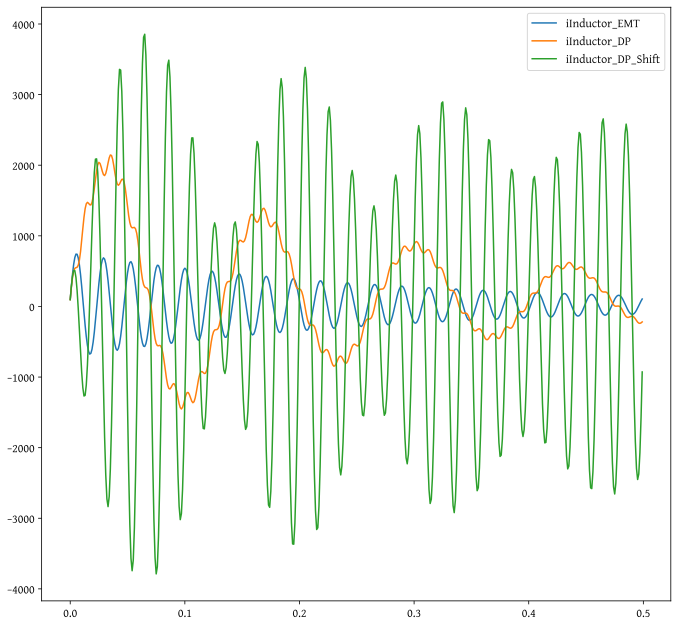

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 12, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}

fig,ax = plt.subplots(1)
fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

# EMT
var_names = ['iInductor']
for var_name in var_names: 
    plt.plot(ts_EMT[var_name].time, ts_EMT[var_name].values, label=var_name+'_EMT')
    
for var_name in var_names: 
   plt.plot(ts_DP[var_name].time, ts_DP[var_name].values, label=var_name+'_DP')

plt.plot(ts_dpsim_dp_emt['iInductor_shift'].time, ts_dpsim_dp_emt['iInductor_shift'].values, label=var_name+'_DP_Shift')

#plt.yticks(np.arange(-800, 800, 50))
plt.legend()

When comparing EMT results with PLECS simulation results, they match, however, DP results even after performing shift doesn't match that of the PLECS simulation result.

TODO: Investigate further

## Real-time Simulation

### DP Simulation

In [16]:
import dpsimpy.dp as simtype
domain = dpsimpy.Domain.DP
name = 'DCGridRealSim_{}'.format(domain)

# Nodes
gnd = simtype.SimNode.gnd #ground node
n0  = simtype.SimNode("n0")
n1  = simtype.SimNode("n1")

# Components
v_s = simtype.ph1.VoltageSource("v_s")
v_s.V_ref = 200.0 
load = simtype.ph1.Resistor("load")
load.R = 10
inductor = simtype.ph1.Inductor("inductor")
inductor.L = 1e-3
capacitor = simtype.ph1.Capacitor("capacitor")
capacitor.C = 14e-3

# Connections that connects nodes through components
v_s.connect([n0, gnd])
inductor.connect([n0, n1])
capacitor.connect([n1, gnd])
load.connect([n1, gnd])

# Specify the topology
sys = dpsimpy.SystemTopology(50.0, [gnd, n0, n1], [v_s, load, inductor, capacitor])

# Specify Simulation parameters
sim = dpsimpy.RealTimeSimulation(name, loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(domain)
sim.set_system(sys)
sim.set_time_step(1e-3)
sim.set_final_time(60.0)

# Specify what to log
log = dpsimpy.Logger(name)
for i in range(0, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])
    

log.log_attribute("iLoad", "i_intf", load)
log.log_attribute("iInductor", "i_intf", inductor)
sim.add_logger(log)


# Run the simulation
sim.run(0)

# Get the data and plot
result = 'logs/{}.csv'.format(name)
tsreal_DP = read_timeseries_csv(result)

ts_realsim_dp_emt = ts.frequency_shift_list(tsreal_DP, 50)

column number: 5
results length: 60001
real column names: []
complex column names: ['iInductor', 'iLoad', 'v0', 'v1', 'v2']


### EMT Simulation

In [17]:

import dpsimpy.emt as simtype
domain = dpsimpy.Domain.EMT
name = 'DCGridRealSim_{}'.format(domain)

# Nodes
gnd = simtype.SimNode.gnd #ground node
n0  = simtype.SimNode("n0")
n1  = simtype.SimNode("n1")

# Components
v_s = simtype.ph1.VoltageSource("v_s")
v_s.V_ref = 200.0 
load = simtype.ph1.Resistor("load")
load.R = 10
inductor = simtype.ph1.Inductor("inductor")
inductor.L = 1e-3
capacitor = simtype.ph1.Capacitor("capacitor")
capacitor.C = 14e-3

# Connections that connects nodes through components
v_s.connect([n0, gnd])
inductor.connect([n0, n1])
capacitor.connect([n1, gnd])
load.connect([n1, gnd])

# Specify the topology
sys = dpsimpy.SystemTopology(50.0, [gnd, n0, n1], [v_s, load, inductor, capacitor])

# Specify Simulation parameters
sim = dpsimpy.RealTimeSimulation(name, loglevel=dpsimpy.LogLevel.debug)
sim.set_domain(domain)
sim.set_system(sys)
sim.set_time_step(1e-3)
sim.set_final_time(60.0)

# Specify what to log
log = dpsimpy.Logger(name)
for i in range(0, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])
    

log.log_attribute("iLoad", "i_intf", load)
log.log_attribute("iInductor", "i_intf", inductor)
sim.add_logger(log)


# Run the simulation
sim.run(1)

# Get the data and plot
result = 'logs/{}.csv'.format(name)
tsreal_EMT = read_timeseries_csv(result)




column number: 5
results length: 60001
real column names: ['iInductor', 'iLoad', 'v0', 'v1', 'v2']
complex column names: []


#### Plotting

/home/infinitive/anaconda3/envs/dpsim/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


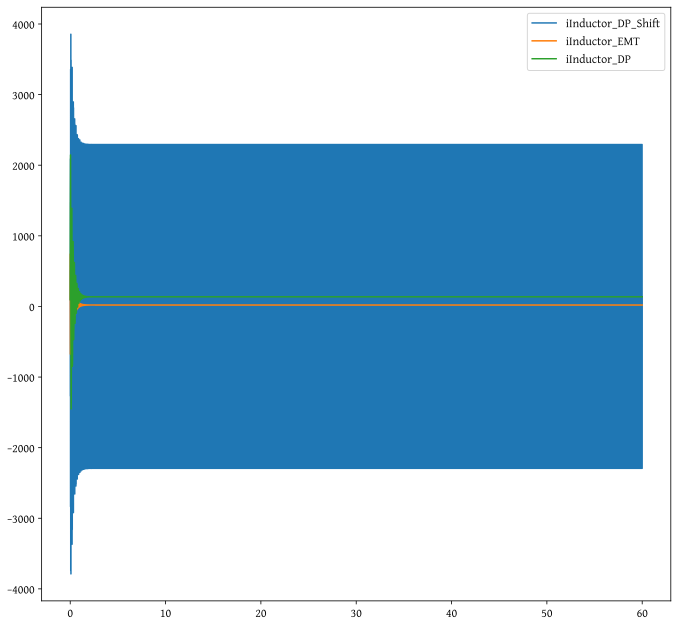

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 12, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}

fig,ax = plt.subplots(1)
fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.plot(ts_realsim_dp_emt['iInductor_shift'].time, ts_realsim_dp_emt['iInductor_shift'].values, label=var_name+'_DP_Shift')


# EMT
var_names = ['iInductor']
for var_name in var_names: 
    plt.plot(tsreal_EMT[var_name].time, tsreal_EMT[var_name].values, label=var_name+'_EMT')
    
for var_name in var_names: 
   plt.plot(tsreal_DP[var_name].time, tsreal_DP[var_name].values, label=var_name+'_DP')


#plt.yticks(np.arange(-800, 800, 50))
plt.legend()